In [7]:
%load_ext autoreload
%autoreload 2

import joblib
from joblib import Parallel, delayed
import warnings
import tensorflow as tf

from src.models import LeNet
from src.data_utils import *

warnings.filterwarnings("ignore")
tf.get_logger().setLevel(tf.logging.ERROR)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LeNet

In [8]:
(X_train, y_train), (X_test, y_test) = get_mnist()
X_train, X_train_db, y_train, y_train_db = split_to_create_db(X_train, y_train, fold_size=0.2)

In [9]:
# prepare the model
lenet = LeNet(
    input_shape=X_train.shape[1:],
    num_classes=10,
)

epochs = 1
mc_rate = 0.97
lenet.set_mc_dropout_rate(mc_rate)
lenet.train(X_train, y_train, X_test, y_test, epochs=epochs, verbose=1)

Training with mc_dropout_rate = 0.9700000286102295.

Train on 48000 samples, validate on 10000 samples
Epoch 1/1
48000/48000 [==============================] - 14s 284us/step - loss: 0.9627 - acc: 0.6612 - val_loss: 0.6610 - val_acc: 0.7678


In [10]:
# lenet.load_model("Assets/lenet-0.76-acc.h5")
y_pred = lenet.model.predict(X_train_db)
probs_accuracy(y_pred, y_train_db)

0.7628333333333334

In [13]:
def mc_dropout(net, X_train, batch_size=1000, dropout=0.5, T=100):
    """
    net: keras model with set_mc_dropout_rate function

    Forward passes T times, then take the variance from all the predictions for each class.
    the mc_dropout score for an example will be the mean of the variances for all the classes.
    y_mc_dropout is the mean of all runs.
    """
    net.set_mc_dropout_rate(dropout)
    model = net.model
    repetitions = []
    # Todo: parallelize
    for _ in range(T):
        pred = model.predict(X_train, batch_size)
        repetitions.append(pred)

    net.set_mc_dropout_rate(0)
    preds = np.array(repetitions)  # T x data x pred

    # average over all passes
    y_mc_dropout = preds.mean(axis=0)

    # get variance from all preds for each example (output: batch x preds classes) each cell is var
    mc = np.var(preds, axis=0)
    # mean of vars of each class (out: one dim array with batch as dim)
    mc_uncertainty = np.mean(mc, axis=-1)

    return y_mc_dropout, -mc_uncertainty

def create_db(net, X_train_db, max_mc_iters):
    from tqdm import tqdm
    db = {}
    for t in tqdm(range(2, max_mc_iters+1)):
        mean, var = mc_dropout(net, X_train_db, T=t)
        db[t] = (mean, var)    
    joblib.dump(db, f"Assets/lenet-0.76-db_{max_mc_iters}_iters.jblib", compress=True)
    print(f"lenet-0.76-db_{max_mc_iters}_iters created")
    return db

In [14]:
ans = create_db(lenet, X_train_db, 1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [61:56:38<00:00, 223.22s/it]


lenet-0.76-db_1000_iters created


In [16]:
db = ans

In [17]:
iters_acc = []
for mc_iters, mean_var_vecs in db.items():
    acc = probs_accuracy(mean_var_vecs[0], y_train_db)
    iters_acc.append((mc_iters, acc))

In [18]:
iters, accs = zip(*iters_acc)
iters_acc = sorted(iters_acc, key=lambda a: a[1], reverse=True)

# Accuracy as mc_iters

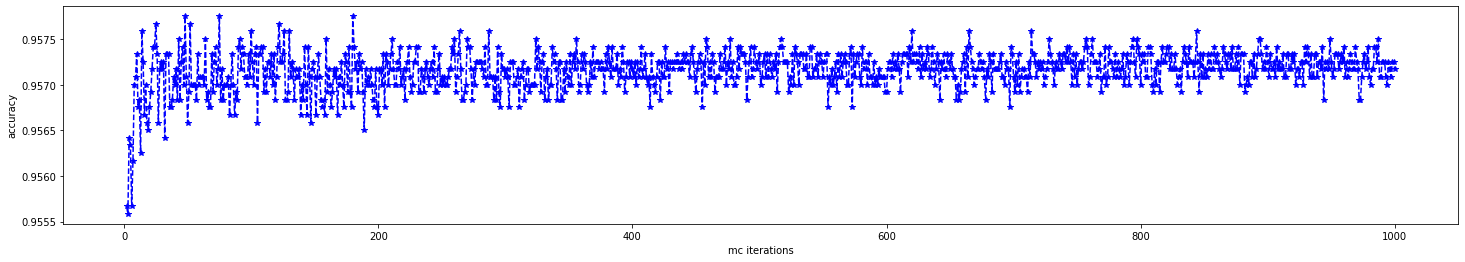

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(25,4))
plt.xlabel('mc iterations')
plt.ylabel('accuracy')
# plt.xticks(range(2,1000), iters)
plt.plot(iters, accs,  marker='*', linestyle='--', color='b')

# Top 10 accuracy and mc_iters

In [21]:
iters_acc[:10]

[(48, 0.95775),
 (75, 0.95775),
 (180, 0.95775),
 (25, 0.9576666666666667),
 (52, 0.9576666666666667),
 (122, 0.9576666666666667),
 (14, 0.9575833333333333),
 (100, 0.9575833333333333),
 (126, 0.9575833333333333),
 (130, 0.9575833333333333)]